## Read Data

In [1]:
# annotations denoting beats
BEAT_CLASSIFIERS = ["N","L","R","B","A","a","J","S","V","r","F","e","j","n","E","/","f","Q","?","|"]

qrs_window_size = 10 # even numbers, so QRS is centered!
net_window_size = 60
batch_size = 32

def extract_signals(record):
    channels = len(record.p_signal[0])
    signals = []
    for channel in range(channels):
        signals.append(record.p_signal[:,channel])
    return signals

def extract_annotations(annotations):
    """Removes first element which is begin marker."""
    positions = annotations.sample[1:]
    labels = annotations.symbol[1:]
    return positions, labels

def filter_annotations(positions, labels, keep):
    """
    Filter out all annotations not denoting beats.
    Keep beat classifiers and corresponding positions.
    """
    filtered_positions = [val for idx, val in enumerate(positions) if labels[idx] in keep]
    filtered_labels = [val for idx, val in enumerate(labels) if labels[idx] in keep]
    return filtered_positions, filtered_labels

In [2]:
import numpy as np
import wfdb

path = '../data/mit-bih-nsrdb/16265'
record = wfdb.rdrecord(path)
annotations = wfdb.rdann(path, 'atr')

signals = extract_signals(record)

ann_positions, ann_labels = extract_annotations(annotations)
ann_positions, ann_labels = filter_annotations(ann_positions, ann_labels, BEAT_CLASSIFIERS)

## Signal Preprocessing

In [3]:
# raw signal
sr = signals[0]

# differentiated raw signal
srd = np.ediff1d(sr)

# averaged signal
Ni = 5 # average window size
sa = np.mean(np.reshape(sr[:-(len(sr) % Ni)], [-1, Ni]), axis=1)

# differentiated averaged signal
sad = np.ediff1d(sa)

print(len(sr))
print(len(srd))
print(len(sa))
print(len(sad))

11730944
11730943
2346188
2346187


## Generate QRS Trigger Stream

In [4]:
qrs = np.zeros(len(sr))

for pos in ann_positions:
    pos_start = pos - qrs_window_size // 2
    pos_end = pos + qrs_window_size // 2
    qrs[pos_start:pos_end] = 1.

## Plot Signals

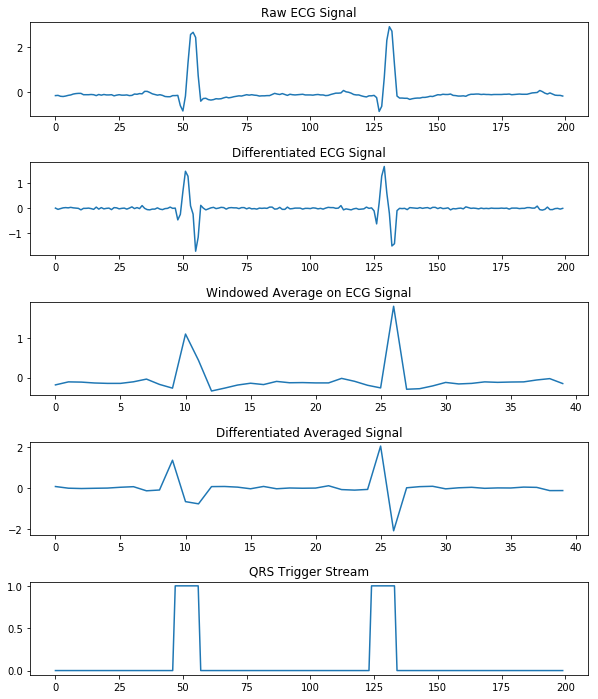

In [5]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 12]
plt.subplots_adjust(hspace=0.5)

x_window_size = 200

plt.subplot(5, 1, 1)
plt.title("Raw ECG Signal")
plt.plot(sr[:x_window_size])

plt.subplot(5, 1, 2)
plt.title("Differentiated ECG Signal")
plt.plot(srd[:x_window_size])

plt.subplot(5, 1, 3)
plt.title("Windowed Average on ECG Signal")
plt.plot(sa[:x_window_size // Ni])

plt.subplot(5, 1, 4)
plt.title("Differentiated Averaged Signal")
plt.plot(sad[:x_window_size // Ni])

plt.subplot(5, 1, 5)
plt.title("QRS Trigger Stream")
plt.plot(qrs[:x_window_size])

plt.show()

## Signal Segmentation (Using Data Generators)

In [6]:
from itertools import chain
from keras.utils import Sequence

class XiangSequence(Sequence):
    def __init__(self, srd, sad, qrs, batch_size, window_size, Ni):
        self.srd = srd
        self.sad = sad
        self.qrs = qrs
        self.batch_size = batch_size
        self.window_size = window_size
        self.Ni = Ni
    
    def __len__(self):
        return int(len(self.srd) / float(self.batch_size))
    
    def __getitem__(self, idx):
        return self.__gen_batch_by_idxs(range(idx*self.batch_size, (idx+1)*self.batch_size))
    
    def __gen_batch_by_idxs(self, idxs):
        srd_windows = np.fromiter(
            chain.from_iterable(
                self.srd[idx:idx+self.window_size] for idx in idxs
            ), 'f'
        )
        srd_windows.shape = self.batch_size, self.window_size, 1
        
        sad_windows = np.fromiter(
            chain.from_iterable(
                self.sad[idx // self.Ni : (idx+self.window_size) // self.Ni] for idx in idxs
            ), 'f'
        )
        sad_windows.shape = self.batch_size, self.window_size // self.Ni, 1
        
        labels = np.fromiter((self.qrs[idx + self.window_size // 2] for idx in idxs), 'f')
        
        return [srd_windows, sad_windows], labels

Using TensorFlow backend.


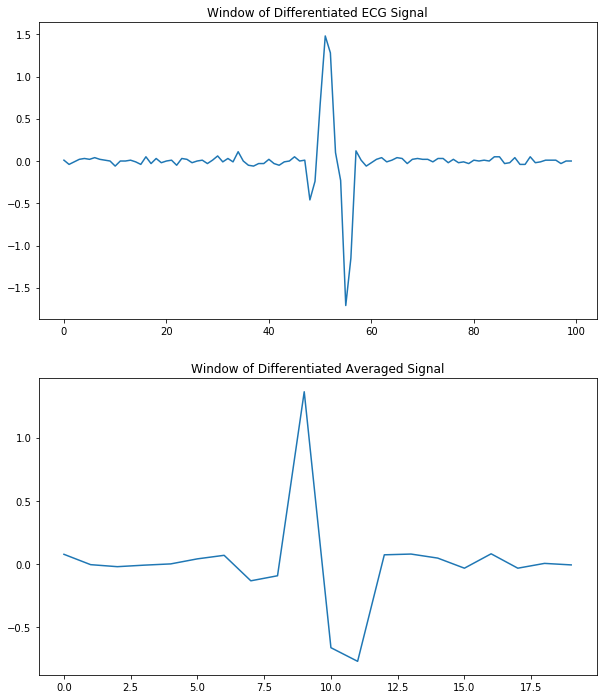

In [7]:
gen = XiangSequence(srd, sad, qrs, 10, 100, Ni)
windows, label = gen.__getitem__(0)

srd_window = windows[0][0]
sad_window = windows[1][0]

plt.subplot(2, 1, 1)
plt.plot(srd_window)
plt.title("Window of Differentiated ECG Signal")

plt.subplot(2, 1, 2)
plt.plot(sad_window)
plt.title("Window of Differentiated Averaged Signal")

plt.show()

## Train / Test / Valid Split

In [8]:
train_begin = 0
valid_begin = round(len(srd) * 0.6)
test_begin = round(len(srd) * 0.8)
end = len(srd)

train_gen = XiangSequence(
    srd[train_begin:valid_begin],
    sad[train_begin // Ni:valid_begin // Ni],
    qrs[train_begin:valid_begin],
    batch_size, net_window_size, Ni)

valid_gen = XiangSequence(
    srd[valid_begin:test_begin],
    sad[valid_begin // Ni:test_begin // Ni], 
    qrs[valid_begin:test_begin],
    batch_size, net_window_size, Ni)

test_gen  = XiangSequence(
    srd[test_begin:end],
    sad[test_begin // Ni:end // Ni],
    qrs[test_begin:end],
    batch_size, net_window_size, Ni)

## Build Neural Network

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 60, 1)        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 12, 1)        0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 58, 32)       128         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 10, 32)       128         input_2[0][0]                    
__________________________________________________________________________________________________
max_poolin

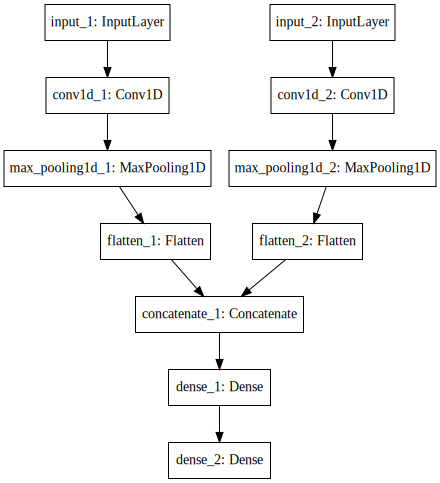

In [9]:
from IPython.display import SVG

from keras.layers import Conv1D, Dense, Flatten, Input, MaxPooling1D
from keras.layers.merge import concatenate
from keras.models import Model
from keras.utils.vis_utils import model_to_dot

visible1 = Input(shape=(60,1))
visible2 = Input(shape=(60//Ni,1))

conv1 = Conv1D(32, kernel_size=3, activation='relu')(visible1)
conv2 = Conv1D(32, kernel_size=3, activation='relu')(visible2)

mp1 = MaxPooling1D(pool_size=3, strides=None)(conv1)
mp2 = MaxPooling1D(pool_size=3, strides=None)(conv2)

fl1 = Flatten()(mp1)
fl2 = Flatten()(mp2)

concatenate1 = concatenate([fl1, fl2])
dense1 = Dense(32, activation='relu')(concatenate1)
dense2 = Dense(1, activation='sigmoid')(dense1)

model = Model(inputs=[visible1, visible2], outputs=dense2)
model.summary()

SVG(model_to_dot(model).create(prog='dot', format='svg'))

## Train Neural Network

In [10]:
model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['accuracy'])

model.fit_generator(
    generator=train_gen,
    steps_per_epoch=1000,
    epochs=5,
    validation_data=valid_gen,
    validation_steps=100,
    shuffle=True)

Epoch 1/5
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0337 - acc: 0.9893 - val_loss: 0.0226 - val_acc: 0.9891
Epoch 2/5
1000/1000 [==============================] - 3s 3ms/step - loss: 0.0190 - acc: 0.9920 - val_loss: 0.0249 - val_acc: 0.9900
Epoch 3/5
1000/1000 [==============================] - 3s 3ms/step - loss: 0.0226 - acc: 0.9907 - val_loss: 0.0240 - val_acc: 0.9919
Epoch 4/5
1000/1000 [==============================] - 3s 3ms/step - loss: 0.0195 - acc: 0.9916 - val_loss: 0.0239 - val_acc: 0.9894
Epoch 5/5
1000/1000 [==============================] - 3s 3ms/step - loss: 0.0172 - acc: 0.9922 - val_loss: 0.0262 - val_acc: 0.9884


In [11]:
labels = model.predict_generator(test_gen, steps=10).flatten()

In [12]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import raccoon.triggerutils as rtu

points = list(rtu.stream_to_points(labels))

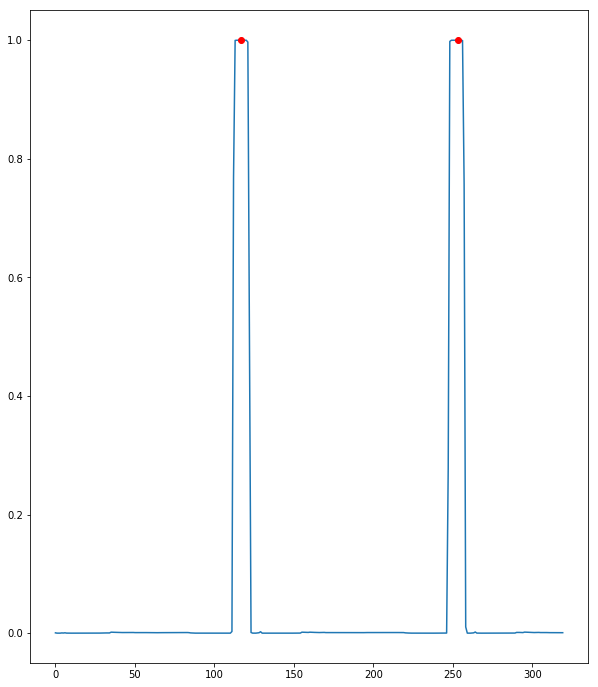

In [13]:
plt.plot(labels)
plt.plot(points, np.ones(len(points)), 'ro')
plt.show()